# Example 9: Cell Viability Measurement

In this notebook we normalize different fluorescent intensity signs to provide normalized cell viability measurement. For beginning let's start with two channels cases, that $I_1$ is high indicating low viability (negative/death signals), and $I_2$ is high for high viability (positive/live signals):

$$\text{Viability}(I_1,I_2) = \frac{1}{1+0.5(e^{-10\cdot(0.5-I_1)}+e^{-10\cdot(I_2-0.5)})}$$

We may generalize it to the formulation:
- ${I_1,I_2,...I_N}$ is the set of intensities of measurement channels.
- Positive signal indexed by the set $P$.
- Negative signal index by the set $N$.
- With pre-normalized channel range to $[0,1]$
Assume a similar exponential sensitivity for each channel, with a shift of 0.5 as the neutral value. Then the generalized viability function for any number of channels becomes:

$$\text{Viability}(I_1,I_2,...,I_N) = \frac{1}{1+\frac{1}{|P|+|N|}(\sum_{i\in P}e^{-10\cdot(I_i-0.5)}+\sum_{j\in N}e^{-10\cdot(0.5-I_j)})}$$
​
Where:

- $\sum_{i\in P}e^{-10\cdot(I_i-0.5)}$ sums the contributions of all positive channels (where higher intensity indicates greater viability).
- $\sum_{j\in N}e^{-10\cdot(0.5-I_j)}$ sums the contributions of all negative channels (where higher intensity indicates lower viability).
- $|P|$ and $|N|$ are the number of positive and negative channels, respectively.
- The scaling factor $\frac{1}{|P|+|N|}$ ensures that the viability function remains properly normalized across any number of channels.

This generalization ensures that signals from any number of channels, both positive and negative, are combined to produce a viability score between 0 and 1.

## Headers

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client
import numpy as np
from cyto.postprocessing.sparse_to_sparse import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 251.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45505,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 251.55 GiB
Comm: tcp://127.0.0.1:34605,Total threads: 4
Dashboard: http://127.0.0.1:44803/status,Memory: 31.44 GiB
Nanny: tcp://127.0.0.1:42355,


## Data Loading

In [3]:
tracks_gfp_df = dd.read_csv("/mnt/Data/UTSE/2023_10_03_Nyeso1_HCT116_framerate_10sec_flowrate_0p15mlperh_analysis/tracks/20231003_roi-5_0-2899_binT-1_cancer/tracks_remapped.csv")
tracks_gfp_df

,Unnamed: 0,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,mean,median,sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size
npartitions=35,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,int64,int64,float64,int64,int64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [4]:
tracks_pi_df = dd.read_csv("/mnt/Data/UTSE/2023_10_03_Nyeso1_HCT116_framerate_10sec_flowrate_0p15mlperh_analysis/tracks/20231003_roi-5_0-2899_binT-1_cancer/tracks_pi_remapped.csv")
tracks_pi_df

,Unnamed: 0,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,mean,median,sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size
npartitions=35,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,int64,int64,float64,int64,int64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
tracks_gfp_df_norm = intensity_norm(tracks_gfp_df,channel="mean", percentile=1)
tracks_gfp_df_norm

,Unnamed: 0,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,mean,median,sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,mean_norm
npartitions=35,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,int64,int64,float64,int64,int64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [6]:
tracks_pi_df_norm = intensity_norm(tracks_pi_df,channel="mean", percentile=1)
tracks_pi_df_norm

,Unnamed: 0,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,mean,median,sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,mean_norm
npartitions=35,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,int64,int64,float64,int64,int64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [7]:
track_gfp_df_norm = tracks_gfp_df_norm.rename(
    columns={
        "mean": "GFP mean",
        "median": "GFP median",
        "sd": "GFP sd",
        "mean_norm": "GFP mean norm"
    }
)

track_pi_df_norm = tracks_pi_df_norm.rename(
    columns={
        "mean": "PI mean",
        "median": "PI median",
        "sd": "PI sd",
        "mean_norm": "PI mean norm"
    }
)

In [8]:
# compute the ddf to df
track_gfp_df_norm = track_gfp_df_norm.compute()
track_pi_df_norm = track_pi_df_norm.compute()

In [9]:
track = left_table_merge(track_gfp_df_norm, track_pi_df_norm, on='label')
track

,Unnamed: 0,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,...,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,GFP mean norm,PI mean,PI median,PI sd,PI mean norm
0,425,426,24.235772,5.800813,0,8,15,27,5.800813,24.235772,...,1000025,0.308649,910,919,219.029670,0.304966,110.882114,113.144531,2.638476,0.000563
1,240,241,9.649180,22.498361,11,0,21,22,22.498361,9.649180,...,1000028,0.609457,156,159,302.897436,0.444950,119.688525,113.144531,13.639799,0.018317
2,384,385,9.101562,8.312500,0,0,17,21,8.312500,9.101562,...,1000029,0.328590,50,51,181.500000,0.449540,111.070312,113.144531,2.964320,0.000943
3,1013,1014,135.993631,8.592357,2,128,14,16,8.592357,135.993631,...,1000039,0.407693,291,291,153.859107,0.078745,110.484076,113.144531,2.680904,0.000000
4,1241,1242,124.785185,3.059259,0,115,10,23,3.059259,124.785185,...,1000040,0.222839,331,331,99.465257,0.317351,111.600000,113.144531,3.453746,0.002010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166317,610,6773032,712.942308,455.788462,447,703,21,26,455.788462,712.942308,...,2900011772,2.789058,66,81,265.257576,0.357829,112.869231,133.328125,2.920804,0.004569
6166318,2158,6774580,40.339623,734.292453,729,35,13,12,734.292453,40.339623,...,2900014130,0.448188,63,81,113.333333,0.014074,112.547170,133.328125,2.704959,0.003920
6166319,2590,6775012,31.705882,743.911765,742,28,5,8,743.911765,31.705882,...,2900014124,11.110681,20,80,197.150000,0.009580,111.882353,133.328125,2.070935,0.002580
6166320,1262,6773684,444.841808,970.751412,965,435,13,23,970.751412,444.841808,...,2900016071,0.294653,63,64,115.365079,0.401688,120.943503,133.328125,6.469963,0.020847


## Viability Calculation

In [10]:
track_via = cal_viability(track,pos_cols=["GFP mean norm"], neg_cols=["PI mean norm"])
track

,Unnamed: 0,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,...,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,GFP mean norm,PI mean,PI median,PI sd,PI mean norm,viability
0,425,426,24.235772,5.800813,0,8,15,27,5.800813,24.235772,...,0.308649,910,919,219.029670,0.304966,110.882114,113.144531,2.638476,0.000563,0.221291
1,240,241,9.649180,22.498361,11,0,21,22,22.498361,9.649180,...,0.609457,156,159,302.897436,0.444950,119.688525,113.144531,13.639799,0.018317,0.534443
2,384,385,9.101562,8.312500,0,0,17,21,8.312500,9.101562,...,0.328590,50,51,181.500000,0.449540,111.070312,113.144531,2.964320,0.000943,0.545981
3,1013,1014,135.993631,8.592357,2,128,14,16,8.592357,135.993631,...,0.407693,291,291,153.859107,0.078745,110.484076,113.144531,2.680904,0.000000,0.028762
4,1241,1242,124.785185,3.059259,0,115,10,23,3.059259,124.785185,...,0.222839,331,331,99.465257,0.317351,111.600000,113.144531,3.453746,0.002010,0.243341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166317,610,6773032,712.942308,455.788462,447,703,21,26,455.788462,712.942308,...,2.789058,66,81,265.257576,0.357829,112.869231,133.328125,2.920804,0.004569,0.325138
6166318,2158,6774580,40.339623,734.292453,729,35,13,12,734.292453,40.339623,...,0.448188,63,81,113.333333,0.014074,112.547170,133.328125,2.704959,0.003920,0.015275
6166319,2590,6775012,31.705882,743.911765,742,28,5,8,743.911765,31.705882,...,11.110681,20,80,197.150000,0.009580,111.882353,133.328125,2.070935,0.002580,0.014613
6166320,1262,6773684,444.841808,970.751412,965,435,13,23,970.751412,444.841808,...,0.294653,63,64,115.365079,0.401688,120.943503,133.328125,6.469963,0.020847,0.427251


### Viability Gradient

In [68]:
from scipy.signal import savgol_filter

def compute_savgol_filter(df, track_id_col="track_id", frame_col="frame", value_col='scalar_value', window_length=10, polyorder=3):
    """
    Applies the Savitzky-Golay filter to smooth the signal and compute its derivative.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the time and signal columns.
    track_id_col: str
        Column name of the cell track id in the DataFrame.
    frame_col : str
        Column name of the time data in the DataFrame.
    value_col : str
        Column name of the value data in the DataFrame.
    window_length : int, optional
        The length of the filter window (must be odd), default is 11.
    polyorder : int, optional
        The order of the polynomial used to fit the samples, default is 3.

    Returns:
    --------
    df : pd.DataFrame
        The input DataFrame with additional columns for the smoothed signal and its derivative.
    """

    # if isinstance(df, pd.DataFrame):
    #     # Estimate the size of the DataFrame in bytes
    #     df_size = df.memory_usage(deep=True).sum()

    #     # Define a target partition size (e.g., 1 GB)
    #     target_partition_size = 0.1*1024 * 1024 * 1024  # 1GB

    #     # Calculate the number of partitions
    #     npartitions = max(1, int(df_size / target_partition_size))  # At least 1 partition

    #     print("npartitions:", npartitions)

    #     df = dd.from_pandas(df,npartitions)

    # Step 1: Sort the DataFrame by track_id and frame
    df_sorted = df.sort_values(by=[track_id_col, frame_col])

    # Step 2: Interpolate missing frames within each track_id
    df_interpolated = df_sorted.groupby(track_id_col).apply(
        lambda group: group.set_index(frame_col).reindex(
            range(group[frame_col].min(), group[frame_col].max() + 1)
        ).interpolate().reset_index()
    ).reset_index(drop=True)
    
    # Step 3: Compute smoothed signal using Savitzky-Golay filter
    def apply_savgol(group):
        # Compute smoothed signal for the current group
        if len(group[value_col]) < window_length:
            group["{}_smoothed".format(value_col)] = savgol_filter(group[value_col], window_length=len(group[value_col]), polyorder=polyorder)
        else:
            group["{}_smoothed".format(value_col)] = savgol_filter(group[value_col], window_length=window_length, polyorder=polyorder)
        
        # Compute the first derivative
        # group["{}_grad".format(value_col)] = savgol_filter(group[value_col], window_length=window_length, polyorder=polyorder, deriv=1, delta=1)
        group["{}_grad".format(value_col)] = np.gradient(group["{}_smoothed".format(value_col)])

        return group 

    df_interpolated = df_interpolated.groupby(track_id_col).apply(apply_savgol).reset_index(drop=True)
        
    # # Step 5: Merge the interpolated data back to the original dataframe based on track_id and frame
    result = pd.merge(df, df_interpolated[[track_id_col, frame_col, "{}_smoothed".format(value_col), '{}_grad'.format(value_col)]],
                      on=[track_id_col, frame_col], how='left')
    # result = pd.merge(df, df_interpolated[[track_id_col, frame_col, "{}_smoothed".format(value_col)]],
                    #   on=[track_id_col, frame_col], how='left')

    return result


In [69]:
track_via_grad = compute_savgol_filter(track_via, track_id_col='track_id', frame_col='frame', value_col='viability', window_length=100, polyorder=3)
track_via_grad

,Unnamed: 0,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,...,tracked length,mean tracked cell size,GFP mean norm,PI mean,PI median,PI sd,PI mean norm,viability,viability_smoothed,viability_grad
0,425,426,24.235772,5.800813,0,8,15,27,5.800813,24.235772,...,919,219.029670,0.304966,110.882114,113.144531,2.638476,0.000563,0.221291,0.239498,-0.000105
1,240,241,9.649180,22.498361,11,0,21,22,22.498361,9.649180,...,159,302.897436,0.444950,119.688525,113.144531,13.639799,0.018317,0.534443,0.594502,-0.025252
2,384,385,9.101562,8.312500,0,0,17,21,8.312500,9.101562,...,51,181.500000,0.449540,111.070312,113.144531,2.964320,0.000943,0.545981,0.549811,0.005141
3,1013,1014,135.993631,8.592357,2,128,14,16,8.592357,135.993631,...,291,153.859107,0.078745,110.484076,113.144531,2.680904,0.000000,0.028762,0.028797,0.000379
4,1241,1242,124.785185,3.059259,0,115,10,23,3.059259,124.785185,...,331,99.465257,0.317351,111.600000,113.144531,3.453746,0.002010,0.243341,0.236549,0.000855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166317,610,6773032,712.942308,455.788462,447,703,21,26,455.788462,712.942308,...,81,265.257576,0.357829,112.869231,133.328125,2.920804,0.004569,0.325138,0.324653,0.000095
6166318,2158,6774580,40.339623,734.292453,729,35,13,12,734.292453,40.339623,...,81,113.333333,0.014074,112.547170,133.328125,2.704959,0.003920,0.015275,0.018225,0.000554
6166319,2590,6775012,31.705882,743.911765,742,28,5,8,743.911765,31.705882,...,80,197.150000,0.009580,111.882353,133.328125,2.070935,0.002580,0.014613,0.026595,-0.005789
6166320,1262,6773684,444.841808,970.751412,965,435,13,23,970.751412,444.841808,...,64,115.365079,0.401688,120.943503,133.328125,6.469963,0.020847,0.427251,0.492000,0.001422


### Single Cell Signal Plot

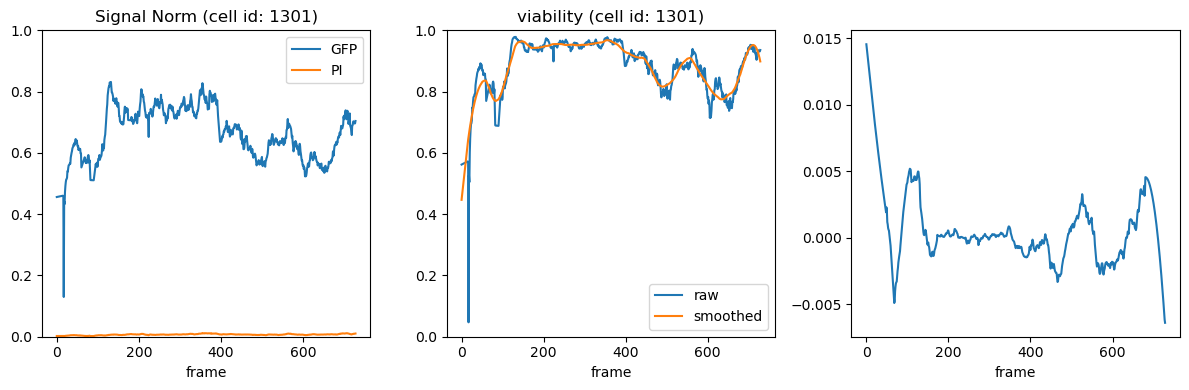

In [70]:
track_id = 1301

res = track_via_grad[track_via_grad["track_id"]==track_id]

fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].plot(res["frame"], res["GFP mean norm"],label="GFP")
axs[0].plot(res["frame"], res["PI mean norm"], label="PI")
axs[0].set_title("Signal Norm (cell id: {})".format(track_id))
axs[0].set_ylim([0,1])
axs[0].set_xlabel("frame")
axs[0].legend()

axs[1].plot(res["frame"], res["viability"],label="raw")
axs[1].plot(res["frame"], res["viability_smoothed"], label="smoothed")
axs[1].set_title("viability (cell id: {})".format(track_id))
axs[1].set_ylim([0,1])
axs[1].set_xlabel("frame")
axs[1].legend()

axs[2].plot(res["frame"], res["viability_grad"],label="raw")
axs[2].set_xlabel("frame")

fig.tight_layout()

## Plot Viability as Function of Time

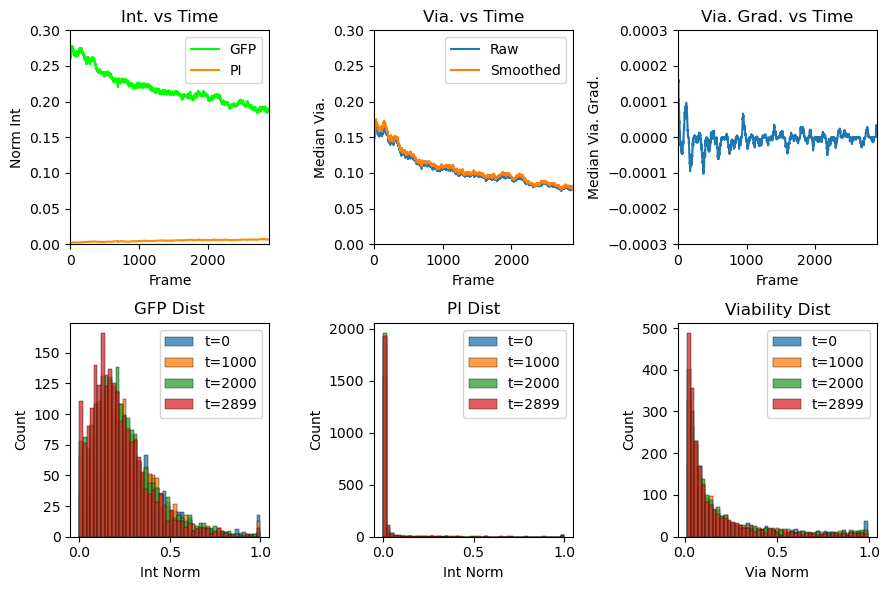

In [71]:
fig, axs = plt.subplots(2,3,figsize=(9,6))

axs[0,0].plot(track_via_grad.groupby('frame')['GFP mean norm'].median(), label="GFP", c="lime")
axs[0,0].plot(track_via_grad.groupby('frame')['PI mean norm'].median(), label="PI", c="darkorange")
axs[0,0].set_xlim(0,track_via["frame"].max() )
axs[0,0].set_ylim(0,0.3)
axs[0,0].set_ylabel("Norm Int")
axs[0,0].set_xlabel("Frame")
axs[0,0].set_title("Int. vs Time")
axs[0,0].legend()

axs[0,1].plot(track_via_grad.groupby('frame')['viability'].median(),label="Raw")
axs[0,1].plot(track_via_grad.groupby('frame')['viability_smoothed'].median(),label="Smoothed")
axs[0,1].set_ylabel("Median Via.")
axs[0,1].set_xlabel("Frame")
axs[0,1].set_title("Via. vs Time")
axs[0,1].set_xlim(0,track_via["frame"].max() )
axs[0,1].set_ylim(0,0.3)
axs[0,1].legend()

axs[0,2].plot(track_via_grad.groupby('frame')['viability_grad'].median())
axs[0,2].set_ylabel("Median Via. Grad.")
axs[0,2].set_xlabel("Frame")
axs[0,2].set_title("Via. Grad. vs Time")
axs[0,2].set_xlim(0,track_via["frame"].max() )
axs[0,2].set_ylim(-3e-4,3e-4)

axs[1,0].set_title("GFP Dist")
sns.histplot(track_via_grad[track_via_grad["frame"]==0]['GFP mean norm'], binwidth=0.02, label="t=0", ax=axs[1,0])
sns.histplot(track_via_grad[track_via_grad["frame"]==1000]['GFP mean norm'], binwidth=0.02, label="t=1000", ax=axs[1,0])
sns.histplot(track_via_grad[track_via_grad["frame"]==2000]['GFP mean norm'], binwidth=0.02, label="t=2000", ax=axs[1,0])
sns.histplot(track_via_grad[track_via_grad["frame"]==2899]['GFP mean norm'], binwidth=0.02, label="t=2899", ax=axs[1,0])
axs[1,0].legend()
axs[1,0].set_xlabel("Int Norm")

axs[1,1].set_title("PI Dist")
sns.histplot(track_via_grad[track_via_grad["frame"]==0]['PI mean norm'], binwidth=0.02, label="t=0", ax=axs[1,1])
sns.histplot(track_via_grad[track_via_grad["frame"]==1000]['PI mean norm'], binwidth=0.02, label="t=1000", ax=axs[1,1])
sns.histplot(track_via_grad[track_via_grad["frame"]==2000]['PI mean norm'], binwidth=0.02, label="t=2000", ax=axs[1,1])
sns.histplot(track_via_grad[track_via_grad["frame"]==2899]['PI mean norm'], binwidth=0.02, label="t=2899", ax=axs[1,1])
axs[1,1].legend()
axs[1,1].set_xlabel("Int Norm")

axs[1,2].set_title("Viability Dist")
sns.histplot(track_via_grad[track_via_grad["frame"]==0]['viability'], binwidth=0.02, label="t=0", ax=axs[1,2])
sns.histplot(track_via_grad[track_via_grad["frame"]==1000]['viability'], binwidth=0.02, label="t=1000", ax=axs[1,2])
sns.histplot(track_via_grad[track_via_grad["frame"]==2000]['viability'], binwidth=0.02, label="t=2000", ax=axs[1,2])
sns.histplot(track_via_grad[track_via_grad["frame"]==2899]['viability'], binwidth=0.02, label="t=2899", ax=axs[1,2])
axs[1,2].legend()
axs[1,2].set_xlabel("Via Norm")

plt.tight_layout()